In [1]:
from scipy.ndimage import gaussian_filter
import numpy  as np
import matplotlib.pyplot as plt
import time
from utils import *
import copy
from hcipy import *
import os.path
import csv
from processing import *

# Introduction

The purpose of this notebook is to introduce the user to the viper_detector module. Viper_detector contains subclasses of HCIpy's NoisyDetector that have been edited to hard code values such as read noise and dark current into the detector, saving the user the trouble of looking up these values. Functions such as EM gain and rolling shutters have also been added or edited in order to accurately represent the performance of these detectors. Basic knowledge of HCIpy's detector class is highly recommended before proceeding.

# Getting Started

## Importing viper_detector

Getting started is very simple. Simply place viper_detector in your main repository and then run:

In [2]:
import viper_detector

## A quick detour: Setting up our telescope.

In order to intialize a viper_detector you must pass it the a focal grid first. Some classes require a propagator and atmosphere layer as well. We will quickly set up a simple telescope so we can demonstrate the functionalities of viper_detector. Feel free to mash Shift + Enter for this next section.

In [3]:
pupil_diameter = 3.048 # (meter)
collecting_area = np.pi * (3.048**2 - 0.9779**2)

f_number = 13 # effective focal ratio
effective_focal_length = pupil_diameter * f_number # (meter)

filter_name = 'V'
wavelength = filters[filter_name]['lambda_eff'] * 1e-6 # (meter)


In [4]:
# Generating the pupil grid
grid_size = 256

pupil_grid = make_pupil_grid(grid_size, diameter=pupil_diameter)

# Adjust spiders to represent Shane pupil
telescope_pupil_generator = make_lick_aperture()
telescope_pupil = telescope_pupil_generator(pupil_grid)

# im = imshow_field(telescope_pupil, cmap='gray', )
# plt.colorbar()
# plt.xlabel('x / D')
# plt.ylabel('y / D')
# plt.show()

In [5]:
seeing = 1.75
outer_scale = 40. # (meter) --> GUESS, NEEDS REFINING
velocity = 20. # (m/s) --> GUESS, NEEDS REFINING
                                    
fried_parameter = seeing_to_fried_parameter(seeing, wavelength)
                             
Cn_squared = Cn_squared_from_fried_parameter(fried_parameter, wavelength)

tau0 = 0.314 * fried_parameter/velocity

# print('r0   = {0:.1f}cm'.format(fried_parameter * 100))
# print('L0   = {0:.1f}m'.format(outer_scale))
# print('tau0 = {0:.1f}ms'.format(tau0 * 1000))
# print('v    = {0:.1f}m/s'.format(velocity))

In [6]:
# Generating phase screens
layer = InfiniteAtmosphericLayer(pupil_grid, Cn_squared, outer_scale, velocity)

phase_screen_phase = layer.phase_for(wavelength) # (radian)
phase_screen_opd = phase_screen_phase * (wavelength / (2 * np.pi)) * 1e6

#imshow_field(phase_screen_opd, vmin=-2*np.pi, vmax=2*np.pi, cmap='RdBu')

In [7]:
# Propagating to focal plane

nairy = 100

focal_grid = make_focal_grid(q=4, 
                             num_airy=nairy,
                             pupil_diameter=pupil_diameter,
                             focal_length = effective_focal_length,
                             reference_wavelength=wavelength)

prop = FraunhoferPropagator(pupil_grid, focal_grid, 
                            focal_length=effective_focal_length)

In [8]:
# Primary parameters
mag = 5 #Vega magnitude in the band of interest
stokes_vector= [1.,0.,0.,0.] #I, Q, U, V

# Companion parameters
contrast = 0.
stokes_ps = [1.,0.,0.,0.] #I, Q, U, V
angular_separation= 2 #Lambda/D

# Exposure time and total number of exposures
exposure_time = 0.01 # (seconds)
exposure_total = 3 

In [9]:
pupil_wavefront = Wavefront(telescope_pupil, wavelength,
                            input_stokes_vector=stokes_vector)
pupil_wavefront.total_power = number_of_photons(mag,filter_name,collecting_area,) #In photons/s


wf_planet = Wavefront(telescope_pupil*np.exp(4j*np.pi*pupil_grid.x*angular_separation/pupil_diameter),
                      wavelength,
                      input_stokes_vector=stokes_ps)
wf_planet.total_power = contrast * number_of_photons(mag,filter_name,collecting_area,) # (photons/s)

# Features

## Initializing a basic detector

To initialize a detector, at bare minimum you must have give it a **focal grid** and a **string corresponding to a filter.**

In [10]:
detector1 = viper_detector.ORCA_Quest(focal_grid, 'V')

Every detector in viper_detector can be initialized in this way

## Full list of detectors

The following is a full list of detectors currently built into viper_detector. The format is name of class, followed by a link to either a brochure or a user manual.

 - ProEM512 - https://www.princetoninstruments.com/wp-content/uploads/2020/10/ProEM-HS_512BX3_datasheet.pdf  

 - iXon897 - https://andor.oxinst.com/assets/uploads/products/andor/documents/andor-ixon-ultra-emccd-specifications.pdf

 - ORCA_Quest - https://www.hamamatsu.com/resources/pdf/sys/SCAS0154E_C15550-20UP_tec.pdf

 - Kinetix - https://www.photometrics.com/wp-content/uploads/2019/10/Kinetix-Datasheet-Rev-A2-060082021.pdf

 - Prime_BSI - https://www.photometrics.com/wp-content/uploads/2019/10/PrimeBSI-Datasheet_Rev_A4_-07312020.pdf

## Accepted Filters

Viper_detector is currently built to accept *'U', 'B', 'V', 'R', and 'I'* from the Generic Johnson filter list.  
More information can be found at:  http://svo2.cab.inta-csic.es/theory/fps/index.php?mode=browse&gname=Generic&gname2=Johnson_UBVRIJHKL&asttype= 

## Learning More about your Detector

All the detectors have important values hardcoded. To extract these values, simply run: 

In [11]:
detector1.read_noise

0.43

## Full List of Hardcoded Values

 - dark_current_rate  
 - read_noise  
 - flat_field  
 - include_photon_noise  
 - max_fps  
 - detector_size  
 - shutter_type  
 - detector_type
 - QE (Quantum Efficiency, depends on the input filter)
 - number_of_subdivisions (Rolling Shutter Only)  
 - full_well_depth (EMCCD Only)

## Initializing an EMCCD detector

For EMCCD detectors, two additional input parameters can be passed to the subclass: EM Gain and EM saturate

In [12]:
detector2 = viper_detector.ProEM512(focal_grid, 'v', 1000, None)

 - EM Gain is a scalar controlled by the user. Defaults to **None**.

 - EM Saturate determines the behavior of the detector when the full well depth of a pixel is exceeded. 
     - **None** means the pixel is capped at the full well depth. 
     - **np.nan** replaces all pixels that exceed full well depth with np.nan.

If you don't know whether or not a detector is an EMCCD, initialize a basic detector at first, then check the detector type

In [13]:
detector3 = viper_detector.iXon897(focal_grid, 'V')
print(detector3.detector_type)

EMCCD


# Functions 

## Edited Functions

### .integrate(wavefront, dt)

Integrate has been modified to include loss of power due to quantum efficiency. The syntax is unchanged. Below we show the difference in outputs due to differing quantum efficiencies of the same detector with different filters.

In [14]:
detector1 = viper_detector.Kinetix(focal_grid, 'U')
detector2 = viper_detector.Kinetix(focal_grid, 'V')

In [15]:
detector1.integrate(prop((layer(pupil_wavefront))), 0.1)
detector2.integrate(prop((layer(pupil_wavefront))), 0.1)
image1 = detector1.read_out()
image2 = detector2.read_out()

Text(0.5, 1.0, 'Quantum Efficiency = 0.427')

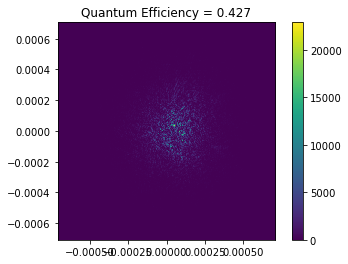

In [16]:
imshow_field(image1)
plt.colorbar()
plt.title("Quantum Efficiency = " + str(detector1.QE))

Text(0.5, 1.0, 'Quantum Efficiency = 0.946')

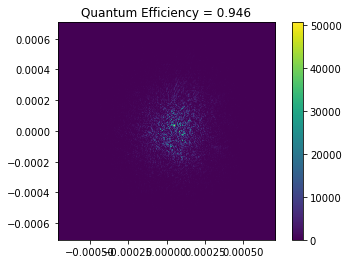

In [17]:
imshow_field(image2)
plt.colorbar()
plt.title("Quantum Efficiency = " + str(detector2.QE))

Notice the different maximums of the color bar on the right. That difference comes from the differing quantum efficiencies

### .read_out() (EMCCDs Only)

For EMCCDs, the read_out() function has been edited to include EM Gain, EM multiplicative noise and saturation of pixels.

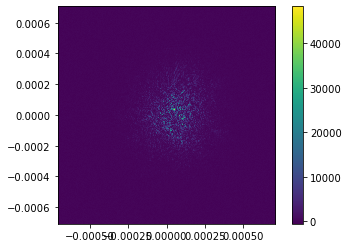

In [18]:
detector1 = viper_detector.ProEM512(focal_grid, 'V', 1, None)
detector1.integrate(prop((layer(pupil_wavefront))), 0.1)
image1 = detector1.read_out()
imshow_field(image1)
plt.colorbar()

If any pixel exceeds the full well depth of the detector, a warning message is printed.

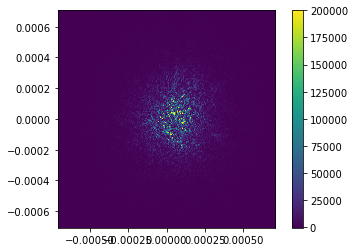

In [19]:
detector1 = viper_detector.ProEM512(focal_grid, 'V', 10, None)
detector1.integrate(prop((layer(pupil_wavefront))), 0.1)
image1 = detector1.read_out()
imshow_field(image1)
plt.colorbar()

The higher the EM Gain, the more pixels will be saturated.

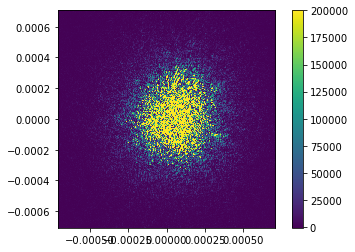

In [20]:
detector1 = viper_detector.ProEM512(focal_grid, 'V', 100, None)
detector1.integrate(prop((layer(pupil_wavefront))), 0.1)
image1 = detector1.read_out()
imshow_field(image1)
plt.colorbar()

This is what we get if we set EM saturate to np.nan instead of None

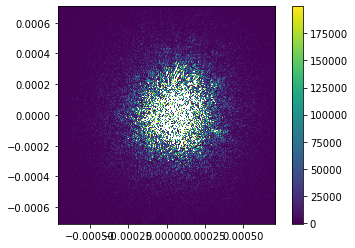

In [21]:
detector1 = viper_detector.ProEM512(focal_grid, 'V', 100, np.nan)
detector1.integrate(prop((layer(pupil_wavefront))), 0.1)
image1 = detector1.read_out()
imshow_field(image1)
plt.colorbar()

In practice, you set the EM Gain to be the same as the read noise at the current frequency

## Additional Functions

### .roll_shutter(wavefronts, layer, prop, exposure_time)

For those detectors that function with a rolling shutter, a roll shutter function has been added to simulate the artifacts produced by a rolling shutter. This function is a combination of .integrate and .read_out and outputs a shaped field. The function takes four inputs:  
 - wavefronts = A list of wavefronts
 - layer = The atmospheric layer
 - prop = The propagator
 - exposure_time = Exposure Time

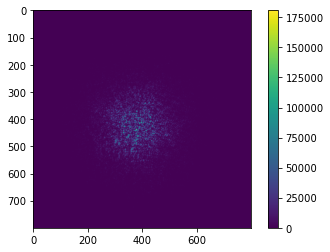

In [22]:
detector1 = viper_detector.ORCA_Quest(focal_grid, 'v')
image1 = detector1.roll_shutter([pupil_wavefront], layer, prop, 0.5)
plt.imshow(image1)
plt.colorbar()

Although it is hard to see, the above image has been constructed by creating 32 different images at 32 different instances of time and then stitching strips of them together. The number 32  was choosen as a balance between performance and accuracy, with more strips being more realistic and less strips improving computation time.